# **IP Reputation**

### We are going to look at detecting Click BOTs from a known campaign sent on Jan 17th @ 9:00AM.

#### But we want to access IP Address behavior prior to that send for likelihood the IP is a BOT

Data was gathered for all click requests for the previous 24 hours and stored in the 2020-01-17.csv file.

### All the requested in this dataset occurred before the campaign we want to study went out.

This is going to let us access the "reputation" of the IP Address.  The campaign we will be studying will have IP Address not used in these 24 hours sample, but this dataset should hold IPs with heavy use as would be expected by BOT devices.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import pytz
from dateutil.tz import tzutc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

### BotDataSet Class

We will use a class to make sure the **loading**, **cleanup** and **sessionization** is done consistantly for both the IP Reputation and the Campaing dataset.  This class will also give us code reuse for the trainging and testing datasets.

In [2]:
exec(open("BotDataSet.py").read())

botDataSet = BotDataSet()
botDataSet.loadCSV('C:/data/2020-01-17.csv')
df = botDataSet.df

In [3]:
pd.options.display.max_columns = None
display(df.head()) 
df.nunique()

,InboxID,Company,List,Campaign,RequestType,SendDate,RequestDate,Link,IPAddress,UserAgent,AS Name,AS Number,CIDR Range,UserID,DomainID,EmailDomain,EmailRootLevelDomain,CountryCode,RegionCode,PostalCode,Lat,Long,OlsonName,SendRequestSeconds,SendRequestSeconds_ln
0,{7C9E652E-AC29-02E0-BE9A-8C43363D665E},{0F96A485-3307-02C7-6F5F-C23BAF3CB945},{79575937-FEB1-AD59-92A5-F2BDCD8EBE25},{4ECAB404-363D-958D-4ECB-99B8D565A66E},Click,2020-01-16 11:32:00,2020-01-16 22:33:00,{CB7A65D9-3644-5395-6E60-E7A556F52E3A},{98302769-08A3-76D3-A660-FB0ED5A313CF},{1047A34C-F98E-2B84-9E69-BCBA6FEEDA97},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{C69692BD-C245-842F-7E3A-0BD44C2E52E8},{9DB20ACE-264D-4774-240E-A86A9FEBC3E6},{5236C5C5-F807-01B8-7308-6369971DE796},.au,AU,05,5000,NaN,NaN,Australia/Adelaide,39660,10.588167
1,{5C245764-B2E8-6C22-65DA-2FA633D2B83D},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{D79E0F2C-4B46-F92F-513C-D9CB4D8150C6},{8708F19F-4880-FA0F-ECCC-0656BDE3B75C},Click,2020-01-17 00:51:00,2020-01-17 04:36:00,{3536BC26-72F7-93D0-09EF-2BF0D5BF5C56},{F879CD11-C8A8-E0F2-A6CF-FFD517892C2D},{67293EF8-7DAD-4A39-0C54-A4499B81C1B0},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{D2D2EECD-86A8-F45B-58AF-ED5ECF0025B6},{7C1BFAEE-63CC-62EB-7343-BB54BBB09F34},{8BBE6FB8-C8D7-CFA8-BF17-AD7BAE195985},.com,AU,05,5000,NaN,NaN,Australia/Adelaide,13500,9.510646
2,{8AB62ABA-0FFD-E217-7EBD-8AD7ECC87559},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{2DFC70F3-E099-652B-A336-E7A215899841},Click,2020-01-16 08:49:00,2020-01-16 19:50:00,{980DC05A-AA27-25B7-7E63-71E70A813088},{7B8A27E6-F6AB-6573-BEF3-334E2E442EF5},{4B0814A1-D331-7033-76B6-F8DB28419C4E},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{07C40EB6-8768-1646-A917-110882272065},{7C1BFAEE-63CC-62EB-7343-BB54BBB09F34},{8BBE6FB8-C8D7-CFA8-BF17-AD7BAE195985},.com,AU,05,5000,NaN,NaN,Australia/Adelaide,39660,10.588167
3,{4DE4BB44-5B00-C6E0-3164-C861E43F0C62},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{ED6C0505-90EC-C31C-3A6A-70A4A193A848},Click,2020-01-16 09:03:00,2020-01-16 17:27:00,{22792626-F2A9-D1AF-AB10-413C1F949A6A},{AF6309B4-2BB3-A707-2F53-131B8DC1D6A4},{F87DC183-2EAD-5AED-B536-4545C440750D},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{59591E4C-6446-5D8C-B4BB-FE284BEC8716},{355469F6-693A-48D0-ACF7-772342C94F4E},{E1EB2A3A-3A96-7B63-669B-7BF029316F88},.com,AU,08,6000,NaN,NaN,Australia/Perth,30240,10.317011
4,{ECB3FB8D-CBA3-8EB3-B97A-88C776102D97},{30ADEAEA-4CB8-2254-1AD2-0D76721A3895},{E46FC402-5D7C-CB5B-0341-30AC5C9E30C6},{2DFC70F3-E099-652B-A336-E7A215899841},Click,2020-01-16 08:48:00,2020-01-16 21:13:00,{93D6CA84-1DFF-2FC5-A0B1-FAB6DE900639},{BB083DCF-AABB-3B20-FB03-6F9DD69BABBE},{F87DC183-2EAD-5AED-B536-4545C440750D},Unknown,Unknown,{14392925-2BAF-FC72-0602-9DB674D6E74D},{ED8E3431-6480-D006-1DFC-4F1BFE952B03},{D75C365A-E14F-D786-8B90-F5AE2456FC87},{FED8E0A7-B13C-C044-F0EB-67C14E5F143D},.com,AU,08,6000,NaN,NaN,Australia/Perth,44700,10.707790


InboxID                  60675
Company                     27
List                        94
Campaign                  1033
RequestType                  1
SendDate                  5411
RequestDate               1441
Link                      5678
IPAddress                55248
UserAgent                 3917
AS Name                     24
AS Number                   25
CIDR Range                 908
UserID                   56880
DomainID                  5581
EmailDomain               5581
EmailRootLevelDomain        90
CountryCode                182
RegionCode                 202
PostalCode                7513
Lat                       4016
Long                      4195
OlsonName                  146
SendRequestSeconds        9018
SendRequestSeconds_ln     9018
dtype: int64

# Only One Metrizable Column in Raw Request Data
## But this metric is one of the major factors that we anticipate will help us identify BOTs.

Mose of the click BOTs are safty devices that examin the risk of the email before it is released to the contact's inbox. So to prevent causing a long delay, the BOTs will want to process the links as soon as they are recieved.  Through manual, most of the suspected BOTs click the message within 1 or 2 minutes after send went out.

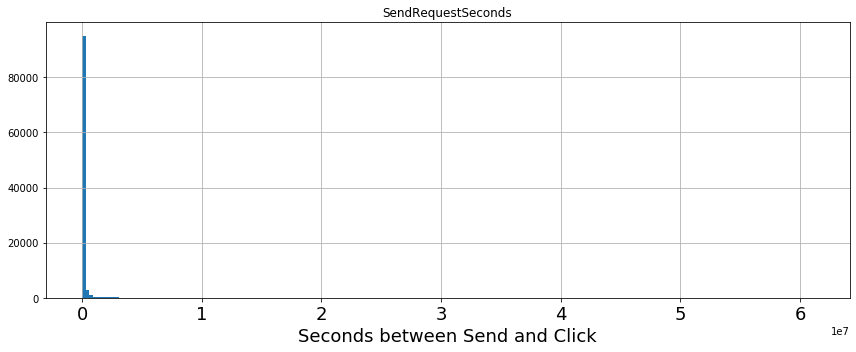

In [4]:
df.hist(column='SendRequestSeconds', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Seconds between Send and Click", fontsize=18)
plt.tight_layout()
plt.show()

## As you can see from the histogram, there is an overwelming number of clicks in the first few minusts after the send.

#### To even out this distribution, the BotDataSet class created a calculated column called **SendRequestSeconds_ln**

This was done by taking the natural log of the SendRequestSeconds.  To avoid zero and negative, the number e was added before the the log was taking.  This make the bottom of the scale = 1.  To give a feel of the upper limit of the this value, 2 days (172800 seconds) would give a value of 14.77.

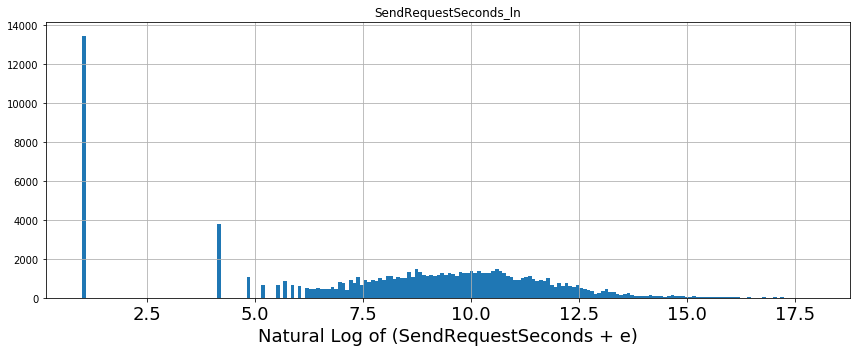

In [5]:
df.hist(column='SendRequestSeconds_ln', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Natural Log of (SendRequestSeconds + e)", fontsize=18)
plt.tight_layout()
plt.show()

## Extend Dataframe with Session Columns

The 4 "SessionIDs" built here are the same one used in the campaign analysis.

In [6]:
max_session_time_gap = timedelta(seconds=120)

session_columns = {'InboxID':'InboxSessionID',
                   'IPAddress':'IPSessionID', 
                   'CIDR Range':'CIDRSessionID', 
                   'AS Number':'ASNSessionID' }

for t in session_columns.items():
    botDataSet.loadSessionColumn(t, max_session_time_gap)

df = botDataSet.df

In [7]:
display_columns = ['RequestDate', 'InboxID', 'IPAddress', 'CIDR Range', 'AS Number']
display_columns.extend(list(session_columns.values()))

sdf = df[display_columns]
display(sdf.head()) 
sdf.nunique()

,RequestDate,InboxID,IPAddress,CIDR Range,AS Number,InboxSessionID,IPSessionID,CIDRSessionID,ASNSessionID
37995,2020-01-16 09:00:00,{582CF80F-649D-3184-ECE6-6EC82905B7CA},{64386B36-2523-58A3-518D-168C6A876DDA},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,-2336411355433902435,3468384035843380116,789220247795684612,-6868546453647685261
54165,2020-01-16 09:00:00,{0C6B4F07-832A-DB0C-7DF4-254161122219},{33B7B276-B6FB-429F-3BD4-C5F7FADC863F},{14392925-2BAF-FC72-0602-9DB674D6E74D},Unknown,8942775634226975254,-2023815208213890966,789220247795684612,-6868546453647685261
2799,2020-01-16 09:00:00,{22D22920-6999-06CC-BAB0-2D366265EF7B},{FC769473-A337-122F-7580-81E139311D2B},{51238901-B830-DFDC-66A9-8DBC82A519E2},20057,4974397380880464958,-6024331573245542490,-7741012011436244181,-5500670637097031789
54801,2020-01-16 09:00:00,{8BC6F258-7FE3-3BD4-EA74-9B6B28FCA4BA},{DD2EF9AE-335E-A4B2-02AD-27993F36E16A},{1F836AD9-A858-453C-6AD0-EB853FA738D9},3356,477319191082878488,-7310296181770784375,-7345159529025082405,-6994970318801237712
54817,2020-01-16 09:00:00,{E94DA0FE-E02B-AC56-A897-490942E7D2E3},{6771E305-765F-D3C6-57D5-357FEB3E4732},{1F836AD9-A858-453C-6AD0-EB853FA738D9},3356,2357125972821123301,-4882803970650678345,-7345159529025082405,-6994970318801237712


RequestDate        1441
InboxID           60675
IPAddress         55248
CIDR Range          908
AS Number            25
InboxSessionID    68089
IPSessionID       69008
CIDRSessionID      8098
ASNSessionID       1798
dtype: int64

# IP Reputation

We built sessionization 3 different ways for the IPs, **IPAddress**, **CIDR Range**, and **AS Number**.

We will start with just looking at IPAddress.  If the unsupervised clustering does not look satisfactory,  we have the option to go up the IP hierarchy.  Just using the IP Address would have very large benefits in the implementation in BOT filtering for a couple of reasons:
- No need to build an ASN Database
- No need to do ASN or CIDR lookups in real-time
- Not all IP address will find a match in the ASN DB

## IP Based Session DataFrames

### We start by grouping on the IPSessionID

This will give us two major advantages:
- We can look at the group of requests as a whole and not just request by request
- The aggregate values produced will give us metrizable data to do K-Means Clustering on

## The IPSession is all requests grouped together as long at there are not gaps grater then 2 minutes between requests.

This means that an IP that is used frequently might have large numbers of requests per IP Session, span many different emails and InboxIDs and have session durations longer than normal.

**UniqueUserAgents/RequestCount** - This may prove to be an important metric.  Normal activity from an IP address usually on has one User Agent.  Also, you would also expect that most organic clicks would only have a few clicks requests in a session (i.e. 1 to 20 range).  But some companies present a single external IP address for all their employees.  In this case, you would expect longer IP Sessions with many different User Agents since multiple people would be making click requests from the same IP address.  So having a low UniqueUserAgents/RequestCount could be critical in differentiating between BOTs and companies that have a single external IP Address.


In [8]:
df_IPSession = df.groupby(['IPSessionID']).agg({
                                                   'IPSessionID':'count',
                                                   'IPAddress':'min',
                                                   'UserAgent':'nunique',
                                                   'InboxID':'nunique', 
                                                   'UserID':'nunique', 
                                                   'EmailDomain':'nunique', 
                                                   'EmailRootLevelDomain':'nunique',
                                                   'Link':'nunique',
                                                   'SendRequestSeconds':'mean', 
                                                   'SendRequestSeconds_ln' : 'mean',
                                                   'RequestDate':lambda x: (x.max() - x.min()).seconds
                                                    })
df_IPSession.rename(columns={"IPSessionID": "RequestCount", 
                         "InboxID": "UniqueInboxIDs", 
                         "UserID": "UniqueEmails", 
                         "UserAgent": "UniqueUserAgents", 
                         "EmailDomain": "UniqueEmailDomains", 
                         "EmailRootLevelDomain": "UniqueEmailRootLevelDomain", 
                         "Link": "UniqueLinks",  
                         "SendRequestSeconds": "MeanSendRequestSeconds", 
                         "SendRequestSeconds_ln": "MeanSendRequestSeconds_ln", 
                         "RequestDate": "SessionDuration"}, 
                inplace=True)

df_IPSession['UniqueUserAgents/RequestCount'] = df_IPSession['UniqueUserAgents'] / df_IPSession['RequestCount']

# display(df_IPSession.head(10)) 

# K Means on IP GroupBy DataFrames

## Create a copy of the group by DataFrame with just the columns we want in the K-Means analysis

In [9]:
agg_columns = ['RequestCount',
               'UniqueInboxIDs',
               'UniqueEmails',
               'UniqueUserAgents',
               'UniqueEmailRootLevelDomain',
               'UniqueLinks',
               'MeanSendRequestSeconds_ln',
               'SessionDuration',
               'UniqueUserAgents/RequestCount']



# Make sure the reduced columns is it's own df is not a view
df_IPSession_agg = df_IPSession[agg_columns].copy()

# Index is 'IPSessionID' which we will use to map back to our origional DataFrame so we can append the KMeanLables we find
print(df_IPSession_agg.index.name)

IPSessionID


## Normalize the aggregations using a scaler
Here we picked the MinMax Scaler to normalize our aggregate columns.

*Note: SendRequestSeconds's PDF is an expoential decay curve.  Since we already have the natual log of column, the MinMax Scaler should still be a good fit.*

In [10]:
mms = MinMaxScaler()
mms.fit(df_IPSession_agg)
df_IPSession_transformed = pd.DataFrame(mms.transform(df_IPSession_agg))
df_IPSession_transformed.columns = agg_columns
df_IPSession_transformed.index = df_IPSession_agg.index

# Index is 'IPSessionID' which we will use to map back to our origional DataFrame so we can append the KMeanLables we find
print(df_IPSession_transformed.index.name)

IPSessionID


### Find # of Clusters to use in the Model
Find the best guess at to the number of clusters to use to ploting sq mean distances of the clusters as we walk the cluster count from 1 to 15

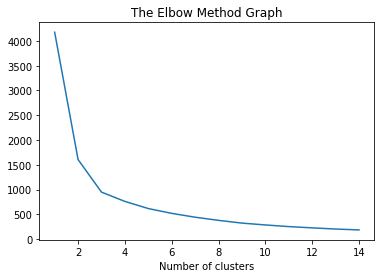

In [11]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_IPSession_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(range(1,15),Sum_of_squared_distances)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.show()

### We see a change in slope around 3, but still has a relatively large avg distance.

### We should try some runs between 3 and 5 and only show the best results below.


## After running 3, 4 and 5, 5 was determined to be the clustering count.

This was done by exporting the K-Means labels and appending the label to the raw non-anonymized data in SQL.  Manual sampling was done to determine the best separation of suspected BOTs and organic click activity.

### Instantiate the KMeans class with clusters = 5
Run fit and get the ndarray of the predicted labels

We will use this array to append a new series onto existing DataFrames


In [12]:
model = KMeans(n_clusters=5)
model.fit(df_IPSession_transformed)
labels = model.predict(df_IPSession_transformed)

print(labels[:20])

[3 1 0 3 2 0 2 3 3 3 2 1 2 2 3 1 2 3 3 2]


#### Make sure the indexes and cardinality of the DataFrames and K-Means lables are a match

In [13]:
print("\
Index of transformed = {}\n\
Index of agg = {}"
      .format( 
              df_IPSession_transformed.index.name, 
              df_IPSession_agg.index.name
             ))

print("\
Len of transformed = {}\n\
Len of agg = {}\n\
Len of lables = {}"
      .format( 
              len(df_IPSession_transformed), 
              len(df_IPSession_agg), 
              len(labels)
              ))

Index of transformed = IPSessionID
Index of agg = IPSessionID
Len of transformed = 69008
Len of agg = 69008
Len of lables = 69008


## Append the KMean Lables to the 2 IP group by DataFrames

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A43C58988>,
      dtype=object)

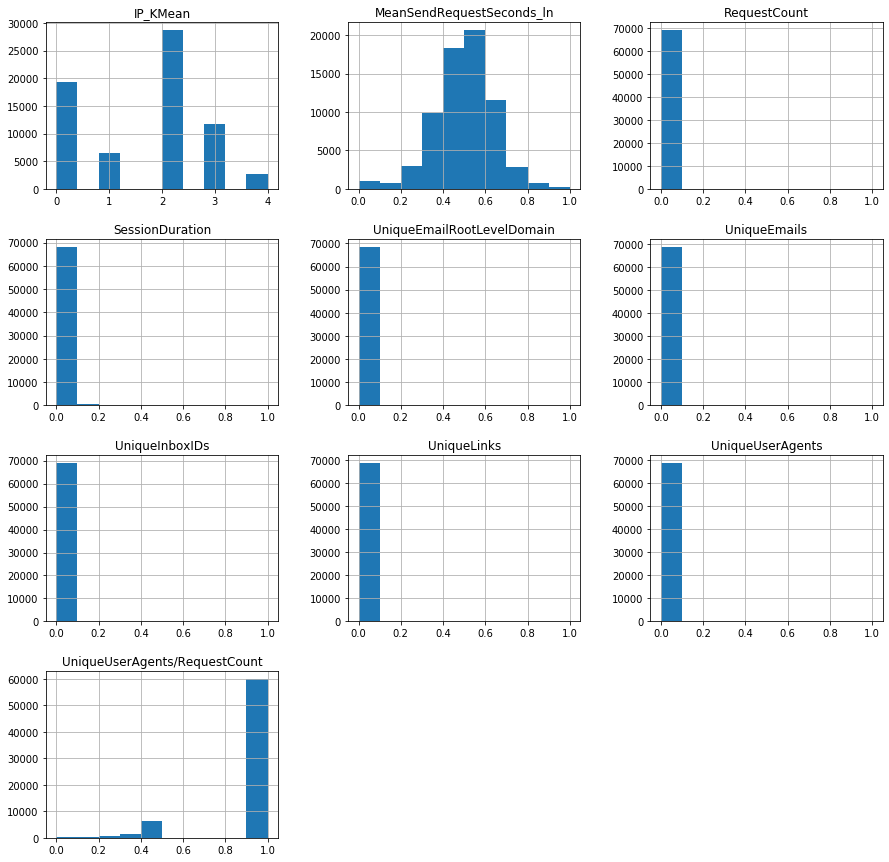

In [33]:
df_IPSession_transformed['IP_KMean'] = labels #Normilized Aggregations
df_IPSession_agg['IP_KMean'] = labels #Not=Normilized Aggregations


df_IPSession_transformed.hist(figsize=(15,15))

## Build visualizations to manually inspect effectiveness of clusters

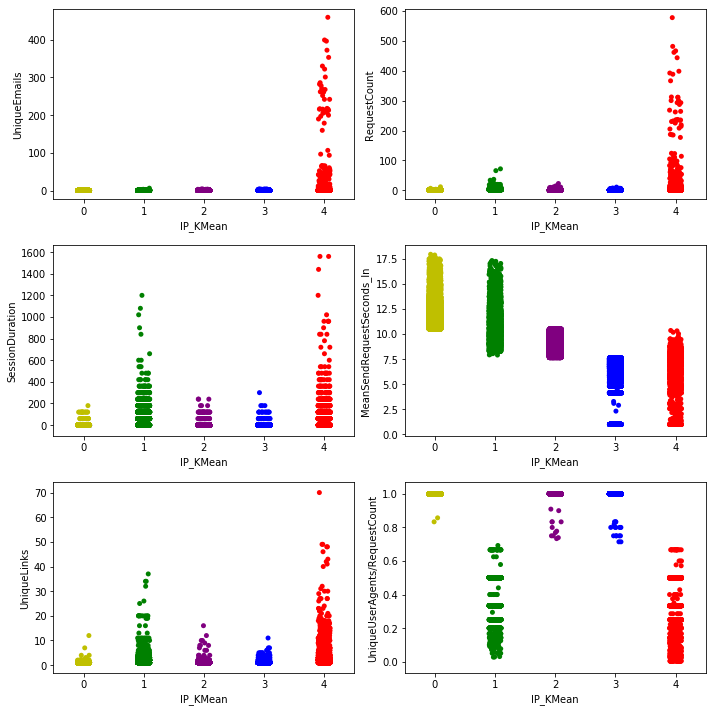

In [34]:
palette = {0:'y', 1:'g',2:'Purple', 3:'b', 4:'r', 5:'Orange'}
f = plt.figure(figsize=(10, 10))
gs = f.add_gridspec(3, 2)

ax = f.add_subplot(gs[0, 0])
sns.stripplot(x='IP_KMean', y='UniqueEmails', palette=palette, data=df_IPSession_agg)

ax = f.add_subplot(gs[0, 1])
sns.stripplot(x='IP_KMean', y='RequestCount', palette=palette, data=df_IPSession_agg)

ax = f.add_subplot(gs[1, 0])
sns.stripplot(x='IP_KMean', y='SessionDuration', palette=palette, data=df_IPSession_agg)

ax = f.add_subplot(gs[1, 1])
sns.stripplot(x='IP_KMean', y='MeanSendRequestSeconds_ln', palette=palette, data=df_IPSession_agg)

ax = f.add_subplot(gs[2, 0])
sns.stripplot(x='IP_KMean', y='UniqueLinks', palette=palette, data=df_IPSession_agg)

ax = f.add_subplot(gs[2, 1])
sns.stripplot(x='IP_KMean', y='UniqueUserAgents/RequestCount', palette=palette, data=df_IPSession_agg)

f.tight_layout()
plt.show()

### Label 4 stands out, esplishely in UniqueEmails and RequestCount
### Low UserAgain to RequestCount ratios for labels 1 and 4

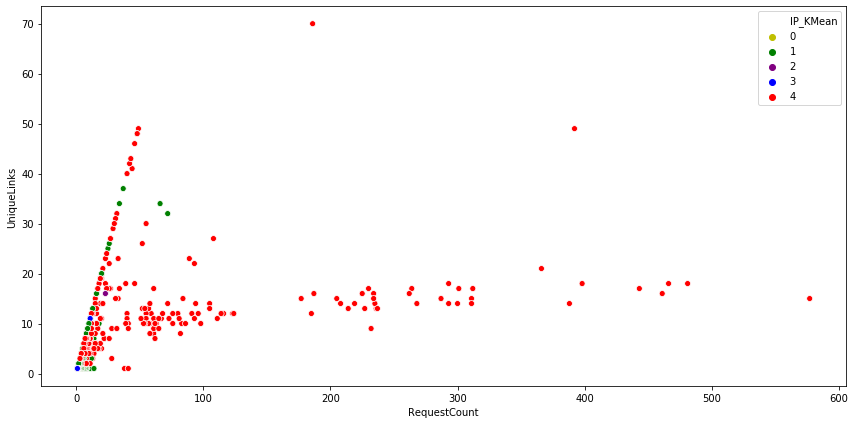

In [35]:
f = plt.figure(figsize=(12, 6))
sns.scatterplot(y='UniqueLinks', x='RequestCount', hue='IP_KMean', palette=palette, data=df_IPSession_agg)
f.tight_layout()
plt.show()

### Most organic click activity will have a unique link pre request.  There will be a few contact's that click on the same link more than one time.

### But label 4 has hundreds of click requests with just 10 to 20 unique links.  This is very suspicious of BOT activity.


In [36]:
#todo: np.seterr(divide='ignore', invalid='ignore')
# Find out what the warnning is about.  i.e. More cleanup on MeanSendRequestSeconds_ln
np.seterr(divide='ignore', invalid='ignore') 

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

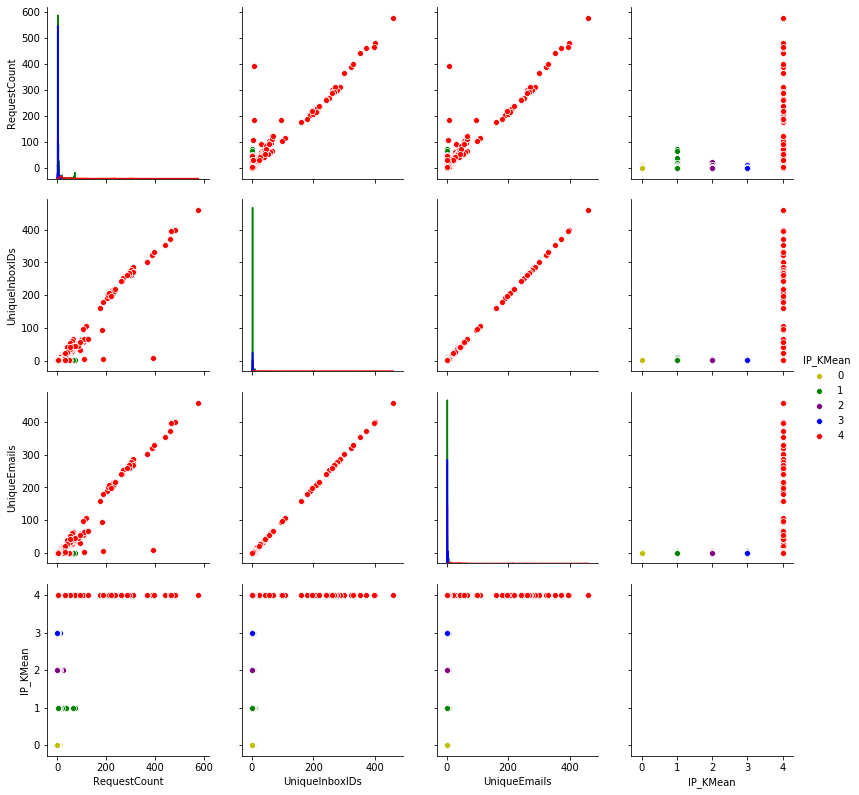

In [37]:
pairplot_columns = agg_columns
pairplot_columns = pairplot_columns[:3]
pairplot_columns.append("IP_KMean")
pairplot_df = df_IPSession_agg[pairplot_columns]
sns.pairplot(pairplot_df, hue="IP_KMean", height=2.8, palette=palette)

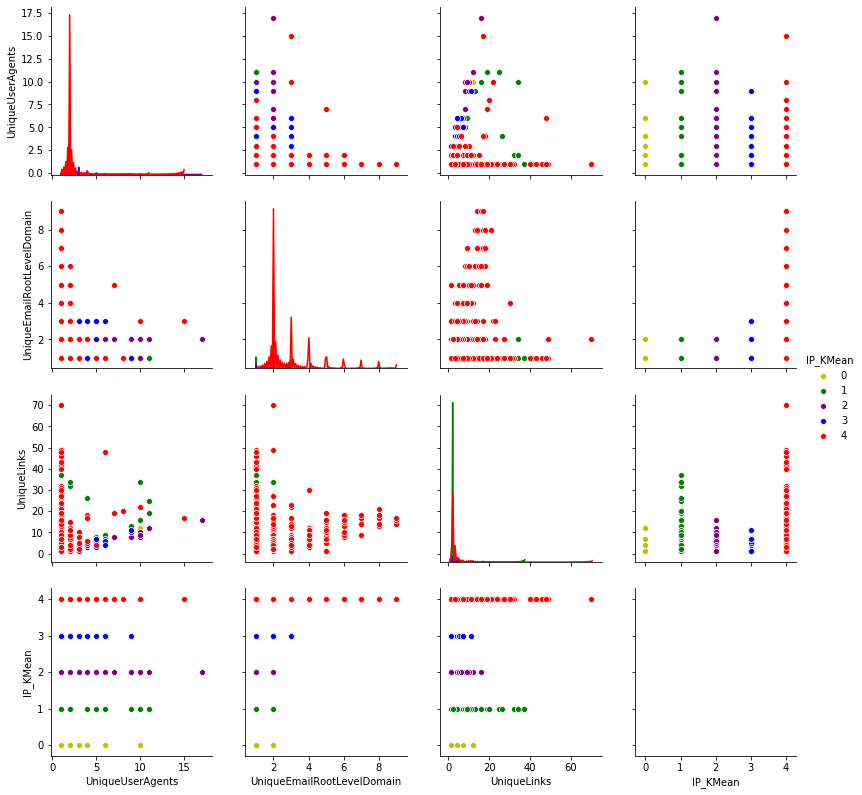

In [38]:
pairplot_columns = agg_columns
pairplot_columns = pairplot_columns[3:6]
pairplot_columns.append("IP_KMean")
pairplot_df = df_IPSession_agg[pairplot_columns]
sns.pairplot(pairplot_df, hue="IP_KMean", height=2.8, palette=palette)

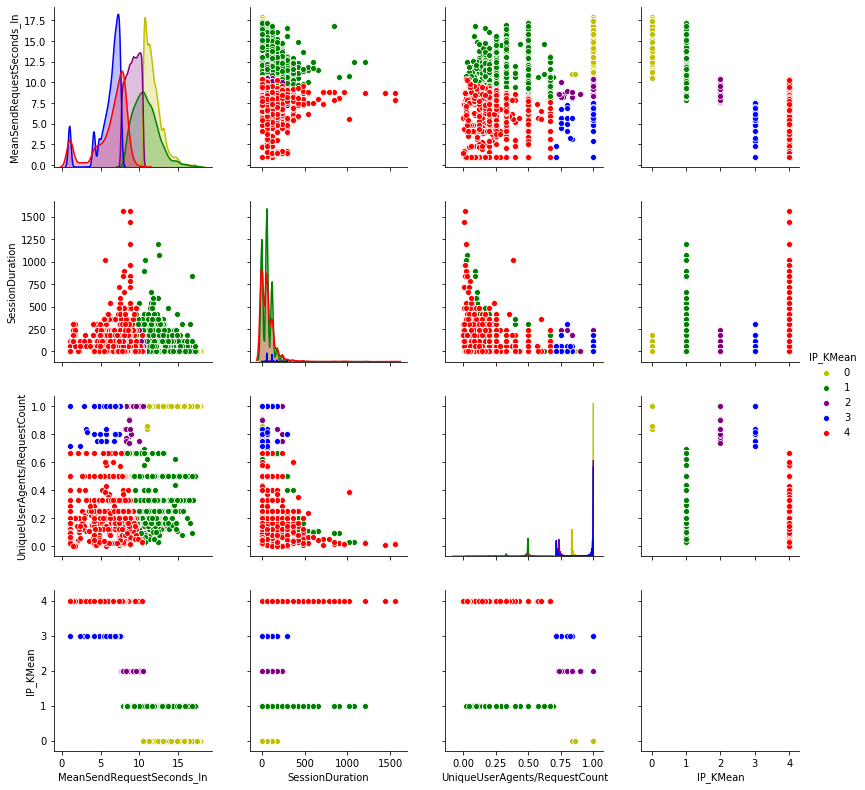

In [39]:
pairplot_columns = agg_columns
pairplot_columns = pairplot_columns[6:]
pairplot_columns.append("IP_KMean")
pairplot_df = df_IPSession_agg[pairplot_columns]
sns.pairplot(pairplot_df, hue="IP_KMean", height=2.8, palette=palette)

# Merge the K-Means labels for IP GroupBy with original df

## Remember, so far we have been looking at the group by DataFrame

### Now that we merged the K-Mean Lables into the raw date, we will see different cardinality since many requests were rolled up in teh group by

In [40]:
df_IPKMeans = pd.merge(df, df_IPSession_agg['IP_KMean'], on="IPSessionID")

In [41]:
nunique_columns = [ 'InboxID',
                    'Company',
                    'List',
                    'Campaign',
                    'Link',
                    'IPAddress',
                    'UserAgent',
                    'AS Name',
                    'AS Number',
                    'CIDR Range',
                    'EmailDomain',
                    'EmailRootLevelDomain']
gb = df_IPKMeans.groupby(['IP_KMean'])[nunique_columns].nunique()
gb=gb.transpose()
gb

IP_KMean,0,1,2,3,4
InboxID,16513,6847,25614,10206,4409
Company,27,26,24,24,23
List,89,71,77,69,55
Campaign,800,473,309,271,181
Link,3290,2463,1749,1341,1430
IPAddress,16836,6002,25233,10526,2192
UserAgent,2016,1141,2229,1167,489
AS Name,22,21,22,23,20
AS Number,23,22,23,24,21
CIDR Range,521,310,645,433,178


## Show distribution of these labels across the AS Names

In [42]:
def groupByPivot(group_column_top, group_column_left, count_column):
    gb = df_IPKMeans.groupby([group_column_top, group_column_left])[count_column].count()
    gb.fillna(0, inplace=True)
    gb = gb.unstack(0)
    gb.fillna(0, inplace=True)
    gb['All'] = gb[0] + gb[1] + gb[3] + gb[4]
    gb.sort_values('All', ascending=False, inplace=True)
    return gb

In [43]:
groupByPivot('IP_KMean', 'AS Name','InboxID')

IP_KMean,0,1,2,3,4,All
AS Name,,,,,,
Unknown,16278.0,12914.0,23644.0,9555.0,4637.0,43384.0
"Amazon.com, Inc.",136.0,660.0,378.0,573.0,18502.0,19871.0
AT&T Mobility LLC,1357.0,1236.0,2319.0,735.0,348.0,3676.0
"MCI Communications Services, Inc. Verizon Business",457.0,362.0,719.0,319.0,128.0,1266.0
"T-Mobile USA, Inc.",302.0,236.0,491.0,146.0,65.0,749.0
"CenturyLink Communications, LLC",208.0,189.0,279.0,89.0,67.0,553.0
TELUS Communications Inc.,181.0,95.0,189.0,72.0,98.0,446.0
Google LLC,153.0,72.0,243.0,81.0,83.0,389.0
"Comcast Cable Communications, LLC",114.0,86.0,203.0,123.0,47.0,370.0


In [44]:
groupByPivot('IP_KMean', 'AS Number','InboxID')

IP_KMean,0,1,2,3,4,All
AS Number,,,,,,
Unknown,16278.0,12914.0,23644.0,9555.0,4637.0,43384.0
16509,17.0,263.0,58.0,466.0,15188.0,15934.0
14618,119.0,397.0,320.0,107.0,3314.0,3937.0
20057,1357.0,1236.0,2319.0,735.0,348.0,3676.0
701,457.0,362.0,719.0,319.0,128.0,1266.0
21928,302.0,236.0,491.0,146.0,65.0,749.0
209,208.0,189.0,279.0,89.0,67.0,553.0
852,181.0,95.0,189.0,72.0,98.0,446.0
15169,153.0,72.0,243.0,81.0,83.0,389.0


In [45]:
groupByPivot('IP_KMean', 'CIDR Range','InboxID').head(20)

IP_KMean,0,1,2,3,4,All
CIDR Range,,,,,,
{14392925-2BAF-FC72-0602-9DB674D6E74D},16278.0,12914.0,23644.0,9555.0,4637.0,43384.0
{4ED21F0C-8573-052A-670B-E4D315133AF5},2.0,42.0,9.0,181.0,6286.0,6511.0
{7EF79BFD-BC3A-903D-C2BD-F5E295ACF4DE},1.0,0.0,2.0,49.0,2100.0,2150.0
{855313BB-3482-1ADA-36A8-5D073B29C265},0.0,0.0,2.0,29.0,1370.0,1399.0
{7E737FAE-7868-5BE1-84B6-EA9011F3B32E},2.0,4.0,12.0,0.0,1209.0,1215.0
{F9164193-183A-7A69-1AE7-25BD6243ED72},0.0,20.0,0.0,33.0,1149.0,1202.0
{6893DEE9-A105-29E9-F9D4-98B3411CF42B},1.0,56.0,1.0,19.0,962.0,1038.0
{19529A3D-5525-64CC-14A9-56324E3C7D1F},1.0,0.0,0.0,12.0,899.0,912.0
{6194D26B-CF4C-CA86-F018-CDE54FED8393},324.0,296.0,585.0,197.0,81.0,898.0


### Save lables to csv file for manual analysis with raw non-anonymized data in SQL.

In [46]:
select_columns = ['IPAddress', 'AS Name', 'AS Number', 'IP_KMean']
output = df_IPKMeans[select_columns].copy()
output.drop_duplicates(inplace=True)
output.to_csv('C:/data/IP_KMean_Lables.csv')
output

,IPAddress,AS Name,AS Number,IP_KMean
0,{64386B36-2523-58A3-518D-168C6A876DDA},Unknown,Unknown,3
1,{33B7B276-B6FB-429F-3BD4-C5F7FADC863F},Unknown,Unknown,2
2,{FC769473-A337-122F-7580-81E139311D2B},AT&T Mobility LLC,20057,1
4,{DD2EF9AE-335E-A4B2-02AD-27993F36E16A},"Level 3 Parent, LLC",3356,3
5,{6771E305-765F-D3C6-57D5-357FEB3E4732},"Level 3 Parent, LLC",3356,3
...,...,...,...,...
101052,{99A40381-59A1-3427-5369-957F6843658A},Unknown,Unknown,0
101053,{FEEF7296-51B4-E675-62CE-0D017761B8DA},Unknown,Unknown,2
101055,{3376B60E-7459-B4F5-294E-A6F9009EDA25},Unknown,Unknown,0
101057,{EBB50052-778F-D369-8542-025CC04371FC},Unknown,Unknown,3
